## Medial Axis

We are going to use the [medial_axis()](http://scikit-image.org/docs/0.10.x/auto_examples/plot_medial_transform.html) transform method, from the Scikit-Image library, to place edges in the medial axis between obstacles.

It works with 1s. Therefore, we have to invert the grid image so that it takes the medial axis of the free space (remember that the grid identifies 1 with obstacles and 0 with free space).

It returns the one-pixel-wide skeleton of the image. The pixel in the medial axis gets a boleand value of TRUE --> medial axis

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.morphology import medial_axis
from skimage.util import invert

from grid import create_grid
from planning import a_star

%matplotlib inline 

plt.rcParams['figure.figsize'] = 13, 13

### Read the obstacle map

In [15]:
# Read the obstacle data contained in the file: colliders.csv
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


### Grid Creation

In [16]:
# Definition of start and goal locations (north, east)
start_ne = (45,  100)
goal_ne = (890, 170)

# Static drone altitude (meters)
drone_altitude = 5

# Safety distance
safety_distance = 2

# Creation of a grid configuration space of the obstacle data: 0=free; 1=obstacle
grid = create_grid(data, drone_altitude, safety_distance)

### Skeleton creation

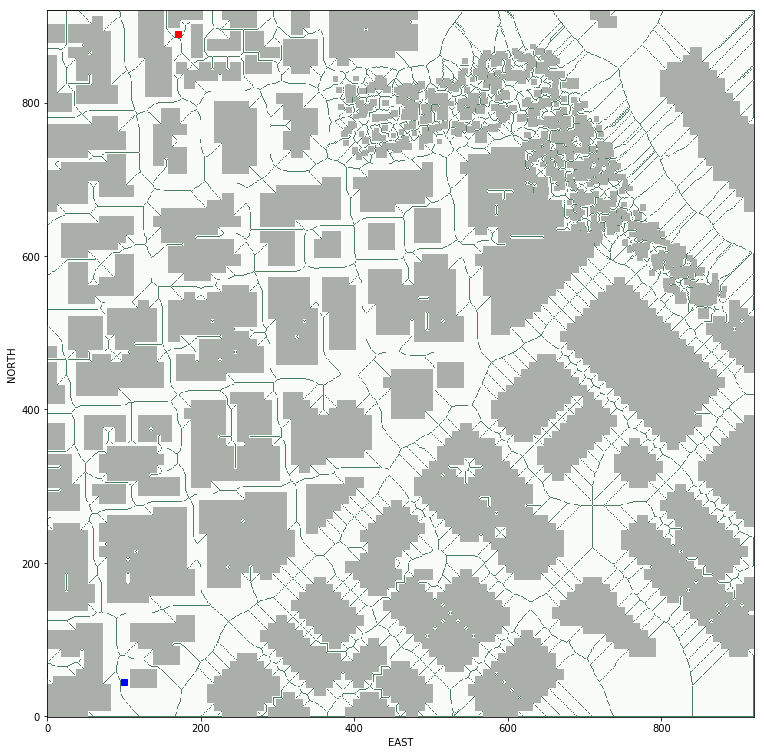

In [17]:
# Calculation of the medial axis (using the skimage method)
# medial_axis works with 1 --> we have to invert the grid so that it takes the medial axis of the free space
# medial_axis outputs boleand values: TRUE --> medial axis
skeleton = medial_axis(invert(grid))

# Plotting the edges on top of the grid along with start and goal locations
# equivalent to
# plt.imshow(np.flip(grid, 0))

plt.imshow(grid, cmap='Greys', origin='lower')
plt.imshow(skeleton, cmap='Greens', origin='lower', alpha=0.7)
    
plt.plot(start_ne[1], start_ne[0], 's', color = 'blue')
plt.plot(goal_ne[1], goal_ne[0], 's', color = 'red')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

### Placing start and goal locations in the skeleton
The start and goal location defined above will not necessarily be on the skeleton so we  must first identify the nearest cell on the 
skeleton to start and goal

Original points:            (45, 100) (890, 170)
Nearest points on skeleton: (45, 95) (885, 167)


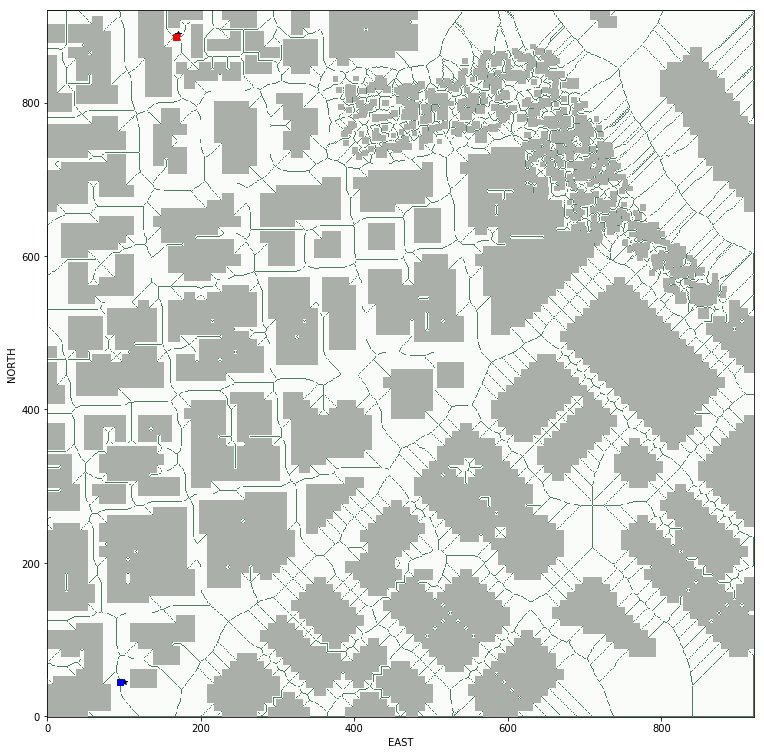

In [18]:
def find_start_goal(skel, start, goal):
    skel_cells = np.transpose(skel.nonzero())
    start_min_dist = np.linalg.norm(np.array(start) - np.array(skel_cells), axis=1).argmin()
    near_start = skel_cells[start_min_dist]
    goal_min_dist = np.linalg.norm(np.array(goal) - np.array(skel_cells), axis=1).argmin()
    near_goal = skel_cells[goal_min_dist]
    
    return near_start, near_goal

skel_start, skel_goal = find_start_goal(skeleton, start_ne, goal_ne)
skel_start, skel_goal = tuple(skel_start), tuple(skel_goal)

print('Original points:           ',start_ne, goal_ne)
print('Nearest points on skeleton:',skel_start, skel_goal)

# Plotting the edges on top of the grid along with start and goal locations
# equivalent to
# plt.imshow(np.flip(grid, 0))

plt.imshow(grid, cmap='Greys', origin='lower')
plt.imshow(skeleton, cmap='Greens', origin='lower', alpha=0.7)
    
plt.plot(start_ne[1], start_ne[0], '*', color = 'black')
plt.plot(goal_ne[1], goal_ne[0], '*', color = 'black')

plt.plot(skel_start[1], skel_start[0], 's', color = 'blue')
plt.plot(skel_goal[1], skel_goal[0], 's', color = 'red')


plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

### Write the heuristic function.

In [19]:
def Euclidean_d(position, goal_position):
    dx = goal_position[0] - position[0]
    dy = goal_position[1] - position[1] 
    return (((dx**2 + dy**2)**0.5))

def Manhattan_d(position, goal_position):
    dx = goal_position[0] - position[0]
    dy = goal_position[1] - position[1]
    return ((abs(dx) + abs(dy)))

### Run A* on the skeleton (and compare with run on grid)

IMPORTANT: Now the planner must have diagonal movements in order to be able to follow the medial axis lane.

In [33]:
# Run A* on the skeleton
# A* consider there is a obstacle with 1; that is why we inverse the skeleton to have the medial_axis=0
# We also have to convert the skeleton from boolean value to integer
path, cost = a_star(invert(skeleton).astype(np.int), Manhattan_d, skel_start, skel_goal)
print("Path length = {0}, path cost = {1}".format(len(path), cost))

Found a path.
Path length = 980, path cost = 1080.4823227814106


In [34]:
# Run A* on the grid
path2, path_cost2 = a_star(grid, Manhattan_d, start_ne, goal_ne)
print("Path length = {0}, path cost = {1}".format(len(path2), path_cost2))

Found a path.
Path length = 896, path cost = 1000.2102448427681


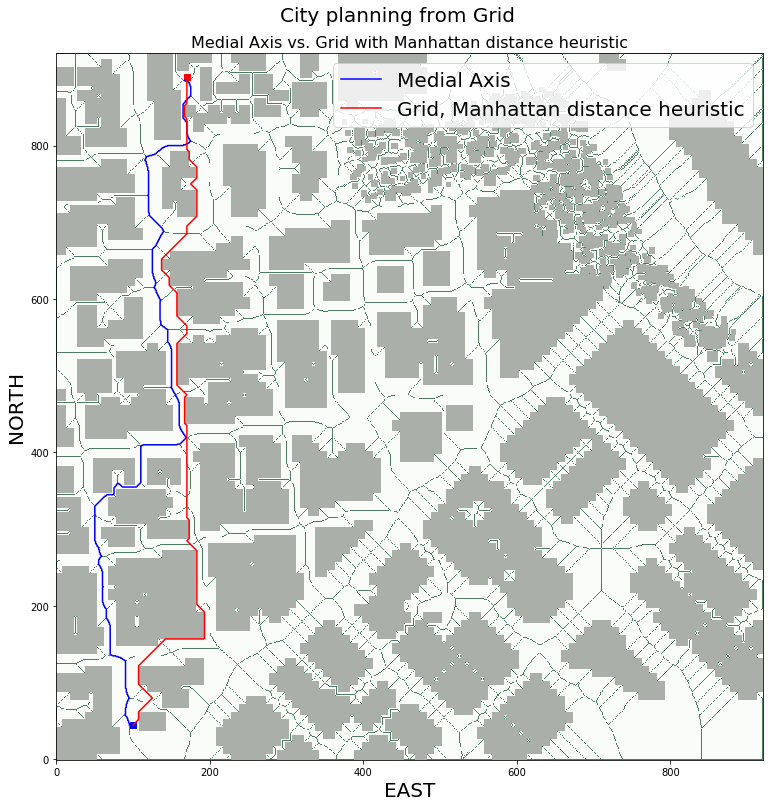

In [35]:
# Plotting
plt.imshow(grid, cmap='Greys', origin='lower')
plt.imshow(skeleton, cmap='Greens', origin='lower', alpha=0.7)
# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 's', color='blue')
plt.plot(goal_ne[1], goal_ne[0], 's', color='red')

pp = np.array(path)
plt.plot(pp[:, 1], pp[:, 0], 'b', label='Medial Axis')
pp2 = np.array(path2)
plt.plot(pp2[:, 1], pp2[:, 0], 'r', label='Grid, Manhattan distance heuristic')

plt.xlabel('EAST', fontsize=20)
plt.ylabel('NORTH', fontsize=20)
plt.suptitle('City planning from Grid', fontsize=20, x=0.5, y=0.93)
plt.title('Medial Axis vs. Grid with Manhattan distance heuristic', fontsize=16, x=0.5, y=1.0)

plt.legend(loc='upper right', fontsize=20)
plt.show()